# SnowPilot database PST analysis

In [1]:
# Auto reload modules
%load_ext autoreload
%autoreload all

In [2]:
# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
# %config matplotlib.inline = ['retina']
%config matplotlib.inline = ['svg']
%matplotlib inline
plt.style.use('styles/omnidracula.mplstyle')

---
## QUERY SNOWPILOT

### Initialize SnowPilot query engine

In [3]:
from oracle import SnowPilotQueryEngine

# This sets the file paths, SnowPilot API endpoints, and loads user credentials
query_engine = SnowPilotQueryEngine()

### Query the SnowPilot database and save PSTs to a pickled DataFrame

In [4]:
# This runs the entire data processing pipeline
# query_engine.run()

In [5]:
# Thesre are the individual pipeline steps
# query_engine.query_xml()
# query_engine.merge_xml()
# query_engine.filter_psts()
# query_engine.count_psts()
# query_engine.xml_to_pkl(pkl_file='psts.pkl')

### Alternatively, query CAAML file formats

This needs to run over night because we can only query weekly data once a minute.

In [6]:
# query_engine.query_caaml(years_back=1, per='week', pause=120)
# query_engine.unzip_caaml()

---
## PARSE THE RAW DATA

### Load and parse the SnowPilot data

In [7]:
from oracle import SnowPilotParser

# Initilize the Parser, which sets the file paths
snowpilot_parser = SnowPilotParser()

# Load and parse the data
snowpilot_parser.parse(pkl_file='psts.pkl')
df_sp = snowpilot_parser.get_dataframe()

# Filter PSTs where the cut length equals the column length (removes all X results)
full_cut = df_sp['lengthOfCut'] == df_sp['lengthOfColumn']
display(
    df_sp[full_cut]
    .pivot_table(index='dataCode', values='nid', aggfunc='count')
    .transpose()
)
df_sp = df_sp[~full_cut]

dataCode,Arr,End,SF,X
nid,59,136,2,80


### Load and parse Literature data

In [8]:
from oracle import SLFDataParser

slf_data_parser = SLFDataParser()
slf_data_parser.parse()
df_vh = slf_data_parser.get_dataframe()

In [9]:
import pandas as pd
from uncertainties import unumpy

# Load dataframes
df_va_end = pd.read_pickle('data/slf/adam2024.pkl')

# Renamce columns and extract the nominal values
df_va_end.rename(columns={'slope_incl': 'incline'}, inplace=True)
df_va_end['incline'] = df_va_end['incline'].apply(unumpy.nominal_values)
df_va_end['Gc'] = df_va_end['Gc'].apply(unumpy.nominal_values)

### Calculate energy release rates

In [24]:
from oracle import PropagationSawTestEngine

# Setup a PST engine
pst_engine = PropagationSawTestEngine(Ewl=0.2, twl=20, nu=0.25, gamma=4.4)

# Filter PSTs where the cut length is greater than half the column length
cut_too_long = df_sp['lengthOfCut'] > 0.6*df_sp['lengthOfColumn']
df_sp = df_sp[~cut_too_long]

# Calculate the fracture toughness
df_sp = pst_engine.calc_fracture_toughness(df_sp, pst_type='vertical')
df_vh = pst_engine.calc_fracture_toughness(df_vh, use_t=True)

display(
    df_sp
    .pivot_table(index='dataCode', values='nid', aggfunc='count')
    .transpose()
)

dataCode,Arr,End,SF
nid,172,1842,279


### Inspect the data

In [25]:
# df_sp.head()

In [26]:
# df_vh.head()

---
## ANALYSIS

### Distinguish full propagation and crack arrest

In [27]:
df_sp_end = df_sp[df_sp.dataCode.str.upper() == 'END']
df_sp_arr = df_sp[df_sp.dataCode.str.upper() == 'ARR']
df_sp_sf = df_sp[df_sp.dataCode.str.upper() == 'SF']
df_sp_x = df_sp[df_sp.dataCode.str.upper() == 'X']

print(df_sp_end.shape[0], 'full propagation results')
print(df_sp_arr.shape[0], 'crack arrest results')
print(df_sp_sf.shape[0], 'slab fracture results')
print(df_sp_x.shape[0], 'no propagation results')

1842 full propagation results
172 crack arrest results
279 slab fracture results
0 no propagation results


In [28]:
END = df_vh['propagation'] == True
SF = df_vh['slab_fracture'] == True

df_vh_end = df_vh[END & ~SF]
df_vh_arr = df_vh[~END & ~SF]
df_vh_sd = df_vh[~END & SF]

print(df_vh_end.shape[0], 'full propagation results')
print(df_vh_arr.shape[0], 'crack arrest results')

149 full propagation results
70 crack arrest results


In [29]:
print(df_va_end.shape[0], 'full propagation results')

88 full propagation results


### Concatenate the dataframes

In [30]:
# Concatenate the dataframes
use = ['Gc', 'D11']
df_end = pd.concat(
    [
        # df_va_end[use],
        df_vh_end[use],
        df_sp_end[use],
    ],
    axis=0,
)
df_arr = pd.concat(
    [
        df_vh_arr[use],
        df_sp_arr[use],
    ],
    axis=0,
)

print(df_end.shape[0], 'full propagation results')
print(df_arr.shape[0], 'crack arrest results')

1991 full propagation results
242 crack arrest results


In [31]:
df_all = pd.concat(
    [
        df_va_end['Gc'],
        df_vh_end['Gc'],
        df_sp_end['Gc'],
        df_vh_arr['Gc'],
        df_sp_arr['Gc'],
    ]
)

print(df_all.shape[0], 'total PSTs')

2321 total PSTs


### Find best fitting distribution

In [32]:
from fitter import Fitter, get_common_distributions
from IPython.utils import io

# Create a Fitter instance, specify the data and the distributions you want to fit
distributions = get_common_distributions()
fitter_Gc_end = Fitter(df_end['Gc'], distributions=distributions)
fitter_Gc_arr = Fitter(df_arr['Gc'], distributions=distributions)
fitter_Gc_all = Fitter(df_all, distributions=distributions)

# Suppress all output during the fit process
with io.capture_output() as captured:
    fitter_Gc_end.fit()
    fitter_Gc_arr.fit()
    fitter_Gc_all.fit()

# Summarize the results
display(fitter_Gc_end.summary(Nbest=3, plot=False))
display(fitter_Gc_arr.summary(Nbest=3, plot=False))
display(fitter_Gc_all.summary(Nbest=3, plot=False))

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.000902,1611.924488,1628.713665,inf,0.025007,1.629480e-01
cauchy,0.011916,1727.997942,1739.190726,inf,0.236134,3.828170e-98
expon,0.056378,3322.539715,3333.732500,inf,0.228032,1.782327e-91


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.060624,1201.423744,1211.890557,inf,0.065296,2.427333e-01
cauchy,0.248089,1477.367111,1484.344987,inf,0.308760,5.520766e-21
gamma,0.473994,999.286411,1009.753224,inf,0.220608,7.986104e-11


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.001358,1618.189570,1635.438830,inf,0.028022,5.125644e-02
cauchy,0.008553,1741.224273,1752.723779,inf,0.233552,8.020053e-112
expon,0.061286,3441.340230,3452.839737,inf,0.238237,2.146198e-116


In [33]:
from fitter import Fitter, get_common_distributions
from IPython.utils import io

# Create a Fitter instance, specify the data and the distributions you want to fit
distributions = get_common_distributions()
fitter_d11_end = Fitter(df_end['D11'], distributions=distributions)
fitter_d11_arr = Fitter(df_arr['D11'], distributions=distributions)

# Suppress all output during the fit process
with io.capture_output() as captured:
    fitter_d11_end.fit()
    fitter_d11_arr.fit()

# Summarize the results
display(fitter_d11_end.summary(Nbest=3, plot=False))
display(fitter_d11_arr.summary(Nbest=3, plot=False))

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
cauchy,0.000388,2132.220769,2143.413554,inf,0.281242,8.601701e-140
lognorm,0.003051,1904.622431,1921.411608,inf,0.032737,2.740900e-02
expon,0.005399,5422.617626,5433.810410,inf,0.283969,1.468623e-142


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
expon,0.009026,6270.677562,6277.655438,inf,0.424503,4.439312e-40
cauchy,0.012693,2279.999255,2286.977130,inf,0.323501,4.847946e-23
lognorm,0.014608,1859.796370,1870.263183,inf,0.073176,1.424992e-01


In [34]:
from fitter import Fitter, get_common_distributions
from IPython.utils import io

# Create a Fitter instance, specify the data and the distributions you want to fit
distributions = get_common_distributions()
fitter_Gc_end = Fitter(df_end['Gc'], distributions=distributions)
fitter_Gc_arr = Fitter(df_arr['Gc'], distributions=distributions)

# Suppress all output during the fit process
with io.capture_output() as captured:
    fitter_Gc_end.fit()
    fitter_Gc_arr.fit()

# Summarize the results
display(fitter_Gc_end.summary(Nbest=3, plot=False))
display(fitter_Gc_arr.summary(Nbest=3, plot=False))

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.000902,1611.924488,1628.713665,inf,0.025007,1.629480e-01
cauchy,0.011916,1727.997942,1739.190726,inf,0.236134,3.828170e-98
expon,0.056378,3322.539715,3333.732500,inf,0.228032,1.782327e-91


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.060624,1201.423744,1211.890557,inf,0.065296,2.427333e-01
cauchy,0.248089,1477.367111,1484.344987,inf,0.308760,5.520766e-21
gamma,0.473994,999.286411,1009.753224,inf,0.220608,7.986104e-11


### Plot data and distribution functions

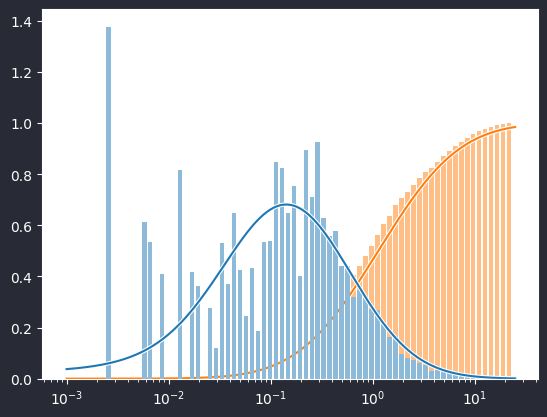

In [35]:
import oracle.plot as plot

plot.distribution(df_end['Gc'], dist_type='lognorm', kind='pdf', log=True)
plot.distribution(df_end['Gc'], dist_type='lognorm', kind='cdf', log=True)

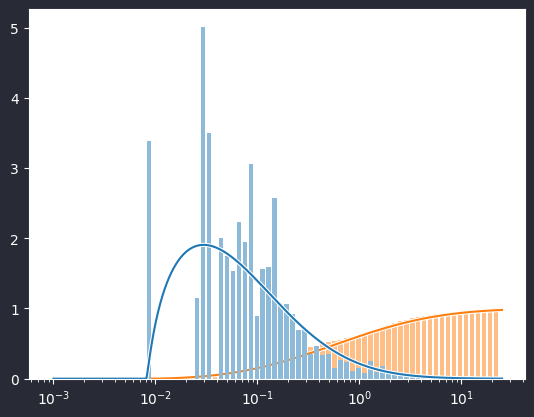

In [66]:
plot.distribution(df_arr['Gc'], dist_type='lognorm', kind='pdf', log=True)
plot.distribution(df_arr['Gc'], dist_type='lognorm', kind='cdf', log=True)

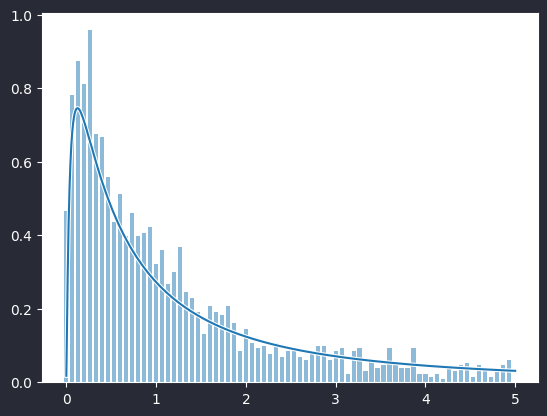

In [37]:
plot.distribution(df_all, dist_type='lognorm', kind='pdf', log=False, range=[0, 5], fit_to_range=False)

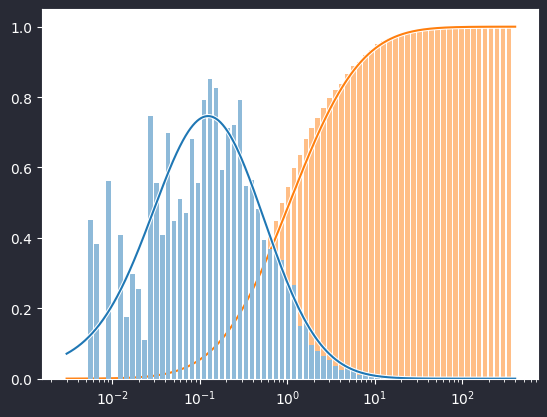

In [57]:
plot.distribution(df_all, dist_type='lognorm', kind='pdf', log=True, range=[3e-3, 4e2], fit_to_range=False)
plot.distribution(df_all, dist_type='lognorm', kind='cdf', log=True, range=[3e-3, 4e2], fit_to_range=False)

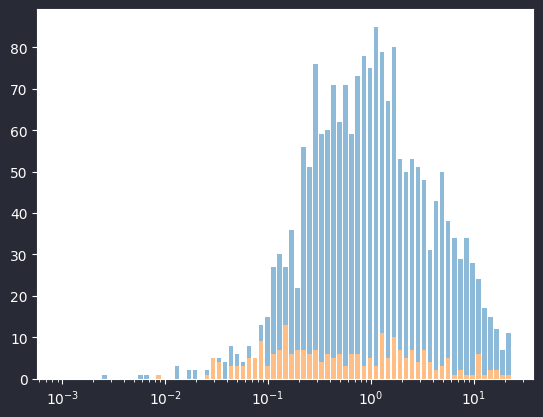

In [58]:
plot.distribution(df_end['Gc'], dist_type='lognorm', kind='pdf', density=False, log=True)
plot.distribution(df_arr['Gc'], dist_type='lognorm', kind='pdf', density=False, log=True)

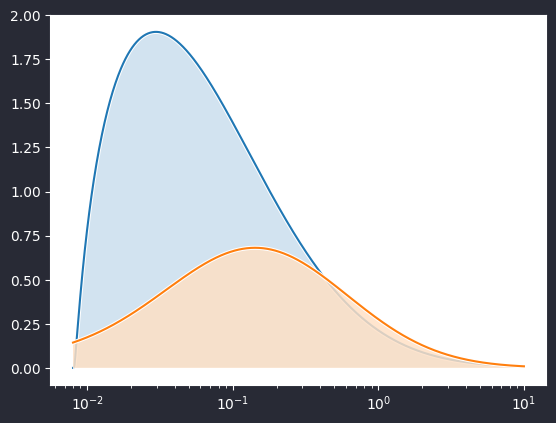

In [59]:
plot.distribution(df_arr['Gc'], dist_type='lognorm', kind='pdf', range=[8e-3, 10], histogram=False, log=True)
# plot.distribution(df_all, dist_type='lognorm', kind='pdf', range=[8e-3, 10], histogram=False, log=True)
plot.distribution(df_end['Gc'], dist_type='lognorm', kind='pdf', range=[8e-3, 10], histogram=False, log=True)

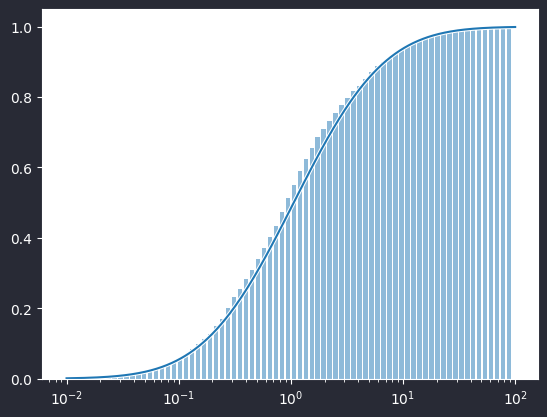

In [65]:
# plot.distribution(df_arr['Gc'], dist_type='lognorm', kind='cdf', range=[1e-2, 100], histogram=True, log=True)
plot.distribution(df_all, dist_type='lognorm', kind='cdf', range=[1e-2, 100], histogram=True, log=True)
# plot.distribution(df_end['Gc'], dist_type='lognorm', kind='cdf', range=[1e-2, 100], histogram=True, log=True)

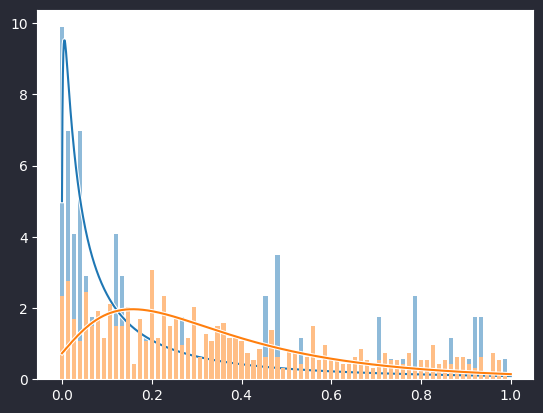

In [64]:
plot.distribution(df_arr['D11'], dist_type='lognorm', kind='pdf', range=[0, 1], density=True, fit_to_range=True)
plot.distribution(df_end['D11'], dist_type='lognorm', kind='pdf', range=[0, 1], density=True, fit_to_range=True)

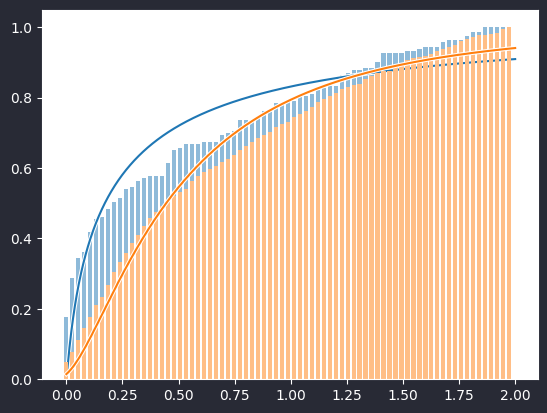

In [28]:
plot.distribution(df_arr['D11'], dist_type='lognorm', kind='cdf', range=[0, 2], density=True, fit_to_range=True)
plot.distribution(df_end['D11'], dist_type='lognorm', kind='cdf', range=[0, 2], density=True, fit_to_range=True)

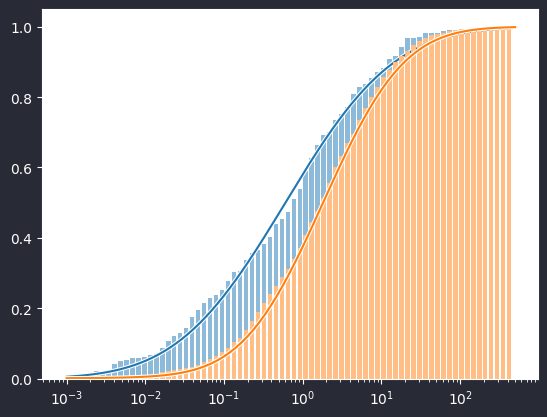

In [29]:
plot.distribution(df_arr['D11'], dist_type='lognorm', kind='cdf', range=[0, 500], density=True, log=True)
plot.distribution(df_end['D11'], dist_type='lognorm', kind='cdf', range=[0, 500], density=True, log=True)

In [30]:
import scipy.stats as stats

def probability(x, s, loc, scale):
    """Probability of full propagation."""
    return 1 - stats.lognorm.cdf(x, s, loc, scale)

In [31]:
# end_params = fitter_end.get_best(method='sumsquare_error')['lognorm']
# arr_params = fitter_arr.get_best(method='sumsquare_error')['lognorm']

gc_end_params = fitter_Gc_end.fitted_param['lognorm']
gc_arr_params = fitter_Gc_arr.fitted_param['lognorm']
gc_all_params = fitter_Gc_all.fitted_param['lognorm']

d11_end_params = fitter_d11_end.fitted_param['lognorm']
d11_arr_params = fitter_d11_arr.fitted_param['lognorm']

Text(0, 0.5, 'Probability of propagation $P(\\mathcal{G}_\\mathrm{c})$')

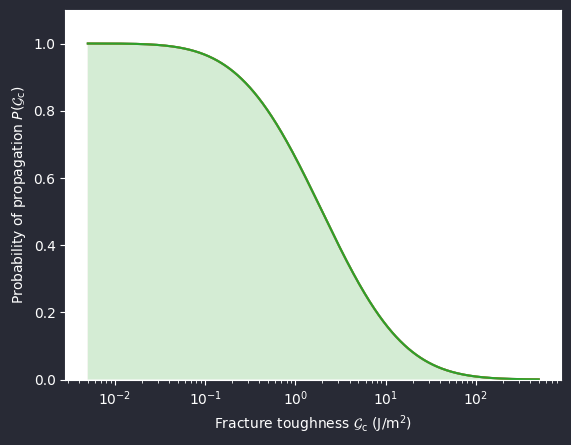

In [32]:
import numpy as np

xmin = 5e-3
xmax = 5e2
log = True

if log:
    x = np.logspace(np.log10(xmin), np.log10(xmax), 1000)
else:
    x = np.linspace(xmin, xmax, 1000)

# Plot background fills
# plt.fill_between(x, probability(x, *gc_end_params), alpha=.2)
plt.fill_between(x, probability(x, *gc_all_params), color='w')
plt.fill_between(x, probability(x, *gc_all_params), alpha=.2)
plt.fill_between(x, probability(x, *gc_all_params), color='w')
plt.fill_between(x, probability(x, *gc_all_params), alpha=.2)
plt.fill_between(x, probability(x, *gc_all_params), color='w')
plt.fill_between(x, probability(x, *gc_all_params), alpha=.2)
# plt.fill_between(x, probability(x, *gc_arr_params), color='w')
# plt.fill_between(x, probability(x, *gc_arr_params), alpha=.2)

# Plot lines
# plt.plot(x, probability(x, *gc_end_params), label='end')
plt.plot(x, probability(x, *gc_all_params), label='all')
plt.plot(x, probability(x, *gc_all_params), label='all')
plt.plot(x, probability(x, *gc_all_params), label='all')
# plt.plot(x, probability(x, *gc_arr_params), label='arr')

# Set limits and scaling
plt.ylim(0, 1.1)
if log:
    plt.xscale('log')
    
# Annotate plot
plt.xlabel(r'Fracture toughness $\mathcal{G}_\mathrm{c}$ (J/m$^2$)')
plt.ylabel(r'Probability of propagation $P(\mathcal{G}_\mathrm{c})$')

# plt.legend()

Text(0, 0.5, 'Probability of propagation $P(\\mathcal{G}_\\mathrm{c})$')

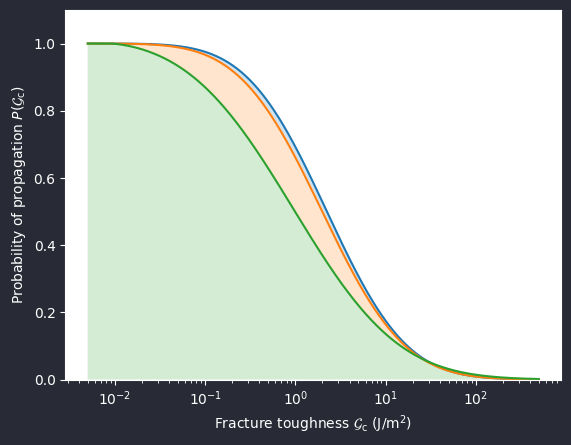

In [33]:
import numpy as np

xmin = 5e-3
xmax = 5e2
log = True

if log:
    x = np.logspace(np.log10(xmin), np.log10(xmax), 1000)
else:
    x = np.linspace(xmin, xmax, 1000)

# Plot background fills
plt.fill_between(x, probability(x, *gc_end_params), alpha=.2)
plt.fill_between(x, probability(x, *gc_all_params), color='w')
plt.fill_between(x, probability(x, *gc_all_params), alpha=.2)
plt.fill_between(x, probability(x, *gc_arr_params), color='w')
plt.fill_between(x, probability(x, *gc_arr_params), alpha=.2)

# Plot lines
plt.plot(x, probability(x, *gc_end_params), label='end')
plt.plot(x, probability(x, *gc_all_params), label='all')
plt.plot(x, probability(x, *gc_arr_params), label='arr')

# Set limits and scaling
plt.ylim(0, 1.1)
if log:
    plt.xscale('log')
    
# Annotate plot
plt.xlabel(r'Fracture toughness $\mathcal{G}_\mathrm{c}$ (J/m$^2$)')
plt.ylabel(r'Probability of propagation $P(\mathcal{G}_\mathrm{c})$')

# plt.legend()

In [89]:
Gc = 4
print(f'Probability of full propagation: {probability(Gc, *gc_end_params):.2f}')
print(f'Probability of crack arrest:     {probability(Gc, *gc_arr_params):.2f}')

Probability of full propagation: 0.36
Probability of crack arrest:     0.25


Text(0, 0.5, 'Probability of stiffness $P(D_{11})$')

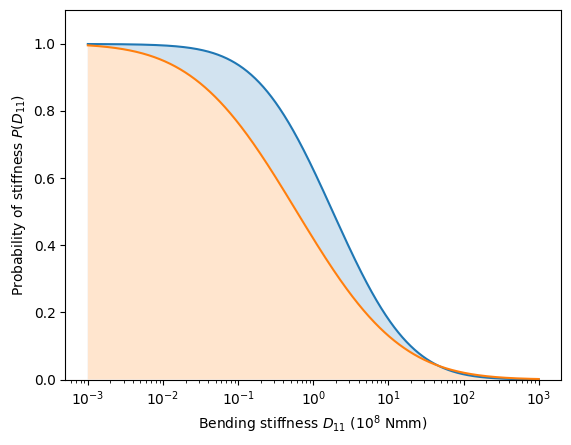

In [90]:
import numpy as np

xmin = 1e-3
xmax = 1000
log = True

if log:
    x = np.logspace(np.log10(xmin), np.log10(xmax), 1000)
else:
    x = np.linspace(xmin, xmax, 1000)

# Plot background fills
plt.fill_between(x, probability(x, *d11_end_params), alpha=.2)
plt.fill_between(x, probability(x, *d11_arr_params), color='w')
plt.fill_between(x, probability(x, *d11_arr_params), alpha=.2)

# Plot lines
plt.plot(x, probability(x, *d11_end_params))
plt.plot(x, probability(x, *d11_arr_params))

# Set limits and scaling
plt.ylim(0, 1.1)
if log:
    plt.xscale('log')
    
# Annotate plot
plt.xlabel(r'Bending stiffness $D_{11}$ ($10^8$ Nmm)')
plt.ylabel(r'Probability of stiffness $P(D_{11})$')

In [91]:
D11 = 1.15
print(f'Probability of full propagation: {probability(D11, *d11_end_params):.3f}')
print(f'Probability of crack arrest:     {probability(D11, *d11_arr_params):.3f}')

Probability of full propagation: 0.596
Probability of crack arrest:     0.398


In [97]:
# pdf_data, hist_bins = np.histogram(df_err['Gc_mean'], bins=75, density=True)
# cdf_data = np.cumsum(pdf_data) * np.diff(hist_bins)
# hist_x = (hist_bins[:-1] + hist_bins[1:]) / 2

# hist_df = pd.DataFrame({'Gc(J/m^2)': hist_x, 'probability_density': pdf_data})
# cum_df = pd.DataFrame({'Gc(J/m^2)': hist_x, 'probability': cdf_data})
# pdf_df = pd.DataFrame({'Gc(J/m^2)': x, 'probability_density': pdf})
# cdf_df = pd.DataFrame({'Gc(J/m^2)': x, 'probability': cdf})
# probability_df = pd.DataFrame({'Gc(J/m^2)': x, 'P': 1 - cdf})

# hist_df.to_csv('data/plots/histogram.txt', index=False, sep='\t')
# cum_df.to_csv('data/plots/cumulative.txt', index=False, sep='\t')
# pdf_df.to_csv('data/plots/pdf.txt', index=False, sep='\t')
# cdf_df.to_csv('data/plots/cdf.txt', index=False, sep='\t')
# probability_df.to_csv('data/plots/probability.txt', index=False, sep='\t')

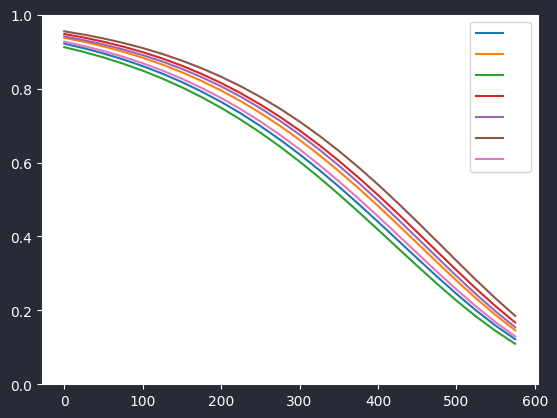

In [216]:
import weac

# Parameters
phi_ = 45  # positive is downslope, negative is upslope
crack_lengths_ = np.arange(0, 600, 25)

plt.figure()

for profile_ in ['A', 'B', 'C', 'D', 'E', 'F', 'H']:

    P_ = []

    for a_ in crack_lengths_:

        # Initialize PST object
        pst_ = weac.Layered(system='-pst', layers=profile_)

        # Set weak-layer properties
        pst_.set_foundation_properties(t=20, E=0.15, update=True)

        # Calculate segmentation
        segments_ = pst_.calc_segments(phi=phi_, L=1000, a=a_)['crack']

        # Assemble model for segments and solve for free constants
        C_ = pst_.assemble_and_solve(phi=phi_, **segments_)

        # Calculate ERR and probability
        Gdif_ = pst_.gdif(C_, phi_, **segments_, unit='J/m^2')
        P_.append(probability(Gdif_[0], *gc_end_params))

    plt.plot(crack_lengths_, P_, label=profile_)

plt.ylim(0, 1)
plt.legend()
plt.show()
# Calculate probability
# propability_function(Gdif_[0])

In [230]:
import weac

# Parameters
phi = 45  # positive is downslope, negative is upslope
t = 20  # mm
E = 0.15  # MPa
L = 1000  # mm
a = 225  # mm

# Initialize PST object
pst = weac.Layered(system='-pst', layers='C')

# Set weak-layer properties
pst.set_foundation_properties(t=t, E=E, update=True)

# Calculate segmentation
segments = pst.calc_segments(phi=phi, L=L, a=a)['crack']

# Assemble model for segments and solve for free constants
C = pst.assemble_and_solve(phi=phi, **segments)

# Calculate ERR and probability
Gdif = pst.gdif(C, phi, **segments, unit='J/m^2')

# Calculate probability
probability(Gdif[0], *gc_all_params)

0.6819123871414612